In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [3]:
def extract_frames_from_video(video_path, output_dir, target_size=(256, 256)):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Read the video file
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break  # End of video

        # Resize frame and save it
        frame_resized = cv2.resize(frame, target_size)
        frame_filename = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame_resized)
        frame_count += 1

    video_capture.release()
    print(f"Frames extracted from {video_path} to {output_dir}")

In [7]:
import os

# Correct the dataset directory path
dataset_dir = "D:\\Dataset_video"  # Remove extra quotes

# Loop through each subfolder and process videos
for subfolder in os.listdir(dataset_dir):
    subfolder_path = os.path.join(dataset_dir, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing subfolder: {subfolder}")


Processing subfolder: 10
Processing subfolder: 12
Processing subfolder: 13
Processing subfolder: 14
Processing subfolder: 16
Processing subfolder: 3
Processing subfolder: 4
Processing subfolder: 5
Processing subfolder: 6
Processing subfolder: 8
Processing subfolder: 9


In [11]:
import os
import cv2
import numpy as np

# Function to load frames from a video file
def load_frames_from_video(video_path, target_size=(256, 256)):
    frames = []
    cap = cv2.VideoCapture(video_path)  # Open the video file
    if not cap.isOpened():  # Check if the video is opened correctly
        print(f"Error: Could not open video {video_path}")
        return frames

    while cap.isOpened():
        ret, frame = cap.read()  # Read a frame from the video
        if not ret:
            break  # If no frame is returned, exit the loop
        frame_resized = cv2.resize(frame, target_size)  # Resize the frame
        frames.append(frame_resized / 255.0)  # Normalize the frame
    cap.release()  # Release the video capture object
    return frames

# Function to process videos from a specific subfolder
def process_and_save_subfolder(dataset_dir, subfolder, output_filename, target_size=(256, 256)):
    all_frames = []  # Store frames for the current subfolder
    subfolder_path = os.path.join(dataset_dir, str(subfolder))  # Get the subfolder path

    if not os.path.isdir(subfolder_path):
        print(f"Warning: {subfolder_path} is not a valid directory.")
        return

    print(f"Processing subfolder: {subfolder}")
    for filename in os.listdir(subfolder_path):
        video_path = os.path.join(subfolder_path, filename)
        if filename.endswith('.MP4'):  # Check if it's an MP4 video file
            print(f"Processing video: {filename}")
            frames = load_frames_from_video(video_path, target_size)
            all_frames.extend(frames)  # Add frames from this video to the list

    # Save frames for this subfolder
    all_frames = np.array(all_frames)
    print(f"Saving {len(all_frames)} frames to {output_filename}")
    np.save(output_filename, all_frames)

# Define the dataset directory and subfolders to process
dataset_dir = 'D:\\Dataset_video'
subfolders = ['3', '4','5','6']  # List of subfolders containing the videos

# Process and save frames for each subfolder
for subfolder in subfolders:
    output_file = f'{subfolder}_frames.npy'
    process_and_save_subfolder(dataset_dir, subfolder, output_file)

print("All subfolders processed and saved individually.")


Processing subfolder: 3
Processing video: cold.MP4
Processing video: high.MP4
Processing video: low.MP4
Processing video: med.MP4
Processing video: warm.MP4
Saving 2764 frames to 3_frames.npy
Processing subfolder: 4
Processing video: cold.MP4
Processing video: high.MP4
Processing video: low.MP4
Processing video: med.MP4
Processing video: warm.MP4
Saving 2715 frames to 4_frames.npy
Processing subfolder: 5
Processing video: cold.MP4
Processing video: high.MP4
Processing video: low.MP4
Processing video: med.MP4
Processing video: warm.MP4
Saving 2640 frames to 5_frames.npy
Processing subfolder: 6
Processing video: cold.MP4
Processing video: high.MP4
Processing video: low.MP4
Processing video: med.MP4
Processing video: warm.MP4
Saving 2640 frames to 6_frames.npy
All subfolders processed and saved individually.


Loaded 2640 frames from 9_frames.npy


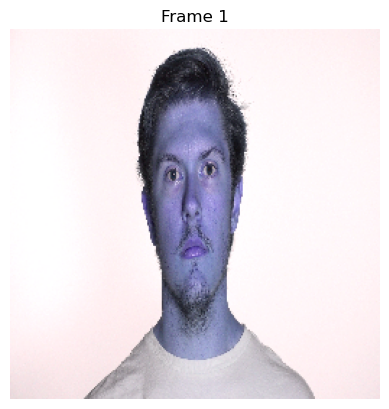

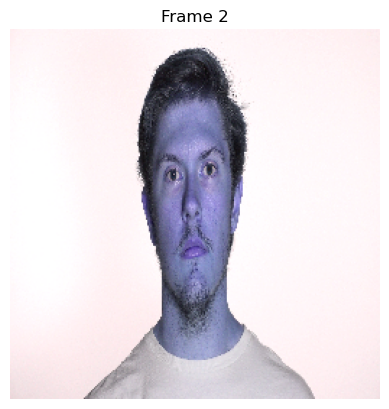

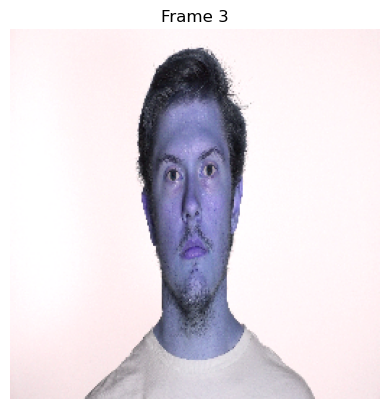

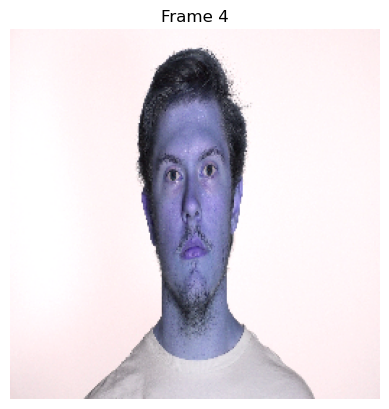

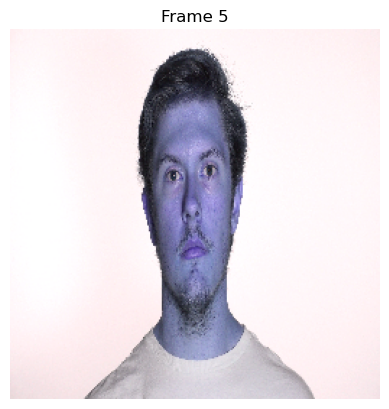

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Load a sample `.npy` file
sample_file = '9_frames.npy'  # Update to one of the generated file names
frames = np.load(sample_file)

# Check the shape and visualize a few frames
print(f"Loaded {frames.shape[0]} frames from {sample_file}")
for i in range(5):  # Display the first 5 frames
    plt.imshow(frames[i])
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
    plt.show()


In [13]:
# Combine frames from all `.npy` files
all_frames = []
for subfolder in subfolders:
    file_name = f'{subfolder}_frames.npy'
    frames = np.load(file_name)
    all_frames.extend(frames)

all_frames = np.array(all_frames)
print(f"Total combined frames: {all_frames.shape}")

# Split into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(all_frames, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Total combined frames: (10759, 256, 256, 3)


MemoryError: Unable to allocate 4.73 GiB for an array with shape (3228, 256, 256, 3) and data type float64

In [15]:
# Improved SRCNN Model
model = Sequential([
    Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(256, 256, 3)),
    BatchNormalization(),
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(3, (5, 5), activation='linear', padding='same')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(X_train, X_train, epochs=20, validation_data=(X_val, X_val), batch_size=16)


C:\Users\Namo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 147s 618ms/step - loss: 0.0315 - val_loss: 0.0026
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 136s 584ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 135s 580ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 136s 584ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 137s 586ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 137s 589ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 136s 581ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 138s 593ms/step - loss: 9.8714e-04 - val_loss: 0.0013
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 146s 625ms/step - loss: 9.2010e-04 - val_loss: 8.2709e-04
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 143s 614ms/step - loss: 8.0075e-04 - val_loss: 7.3990e-04
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 138s 592ms/step - loss: 7.0938e-04 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


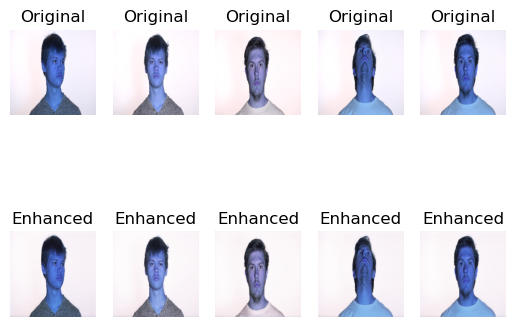

In [48]:
# Save the model
model.save('my_model.keras')

# Test the model
reconstructed = model.predict(X_test[:5])

# Visualize original and enhanced images
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i])
    plt.title("Enhanced")
    plt.axis('off')

plt.show()


Enter the path to the image:  D:\plots\images2.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


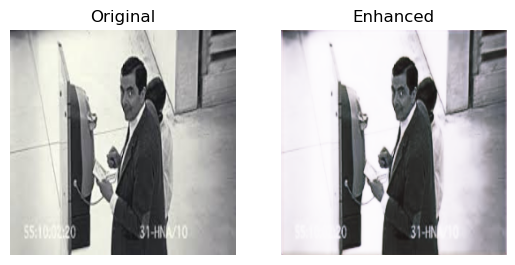

In [7]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('my_model.keras')

# Function to enhance an image
def enhance_image(image_path, model, target_size=(256, 256)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Failed to load the image at {image_path}. Check the file path or format.")

    # Resize and normalize the image
    image_resized = cv2.resize(image, target_size) / 255.0  # Normalize
    image_resized = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    
    # Predict the enhanced image
    enhanced_image = model.predict(image_resized)[0]  # Remove batch dimension
    enhanced_image = (enhanced_image * 255).astype(np.uint8)  # Convert back to 8-bit
    return enhanced_image

# Input image path
image_path = input("Enter the path to the image: ")

try:
    # Enhance the image
    enhanced_image = enhance_image(image_path, model)
    
    # Display original and enhanced images
    original_image = cv2.imread(image_path)
    original_image_resized = cv2.resize(original_image, (256, 256))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image_resized, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced")
    plt.axis('off')

    plt.show()

except ValueError as e:
    print(e)
